### Comparison of the coherence metric between the original and surrogate data

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
import seaborn               as     sns
from   tqdm                  import tqdm
from   xfrites.conn.conn_coh import conn_coherence_wav

from GDa.session             import session_info, session
from GDa.signal.surrogates   import trial_swap_surrogates, phase_rand_surrogates

#### Loading data - for correct task trials

In [2]:
# Instantiate class
s = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,
            slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])
# Read data from .mat files
s.read_from_mat()

In [3]:
idx  = s.trial_info[(s.trial_info['trial_type']==1.0) \
                    & (s.trial_info['behavioral_response']==1.0)].trial_index.values

In [4]:
data = s.data.sel(trials=idx)#.isel(roi=[47,48])

#### Generate trial randomization surrogates

In [5]:
seeds     = np.arange(0, 10, dtype=int) * 100

data_surr = []
for seed in tqdm( seeds ):
    data_surr += [trial_swap_surrogates(data,seed=seed,verbose=False)]
data_surr = xr.concat(data_surr, dim="seeds")

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


#### Generate randomized phase surrogates

In [22]:
#seeds     = np.arange(0, 10, dtype=int) * 100

#data_surr = []
#for seed in tqdm( seeds ):
#    data_surr += [phase_rand_surrogates(data,val=0,seed=seed,verbose=False,n_jobs=-1)]
#data_surr = xr.concat(data_surr, dim="seeds")

#### Computing coherence

In [9]:
sm_times = 300
sm_freqs = 1
# Downsampling factor
delta = 15       
mode  = 'morlet'
foi   = np.array([
        [0.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])
n_freqs   = 50
#freqs        = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
freqs     = np.concatenate( (np.linspace(foi[0,0], foi[0,1], 10, endpoint=False), 
                             np.linspace(foi[1,0], foi[1,1], 10, endpoint=False), 
                             np.linspace(foi[2,0], foi[2,1], 10, endpoint=False), 
                             np.linspace(foi[3,0], foi[3,1], 10, endpoint=False), 
                             np.linspace(foi[4,0], foi[4,1], 10, endpoint=False)  ) )
n_cycles  = freqs/2
decim_at  ='tfd'

x_s, x_t  = np.triu_indices(data.sizes['roi'], k=1)
pairs     = np.array([x_s,x_t]).T

In [10]:
# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times=data.time, roi=data.roi, foi=foi, n_jobs=20,
    sfreq=data.attrs['fsample'], mode=mode, n_cycles=n_cycles, decim=15,
    sm_times=300, sm_freqs=1, block_size=1, decim_at=decim_at
)

In [11]:
coh      = conn_coherence_wav(data, **kw).astype(np.float32)

Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   18.8s remaining:    4.2s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   21.7s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

In [12]:
coh_surr = []
for i in tqdm( range(10) ):
    coh_surr += [conn_coherence_wav(data_surr.isel(seeds=i), **kw).astype(np.float32)]
coh_surr = xr.concat(coh_surr, dim="seeds")

  0%|          | 0/10 [00:00<?, ?it/s]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   20.3s remaining:    4.6s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   23.2s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 10%|█         | 1/10 [02:55<26:22, 175.82s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   20.2s remaining:    4.5s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   23.0s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 20%|██        | 2/10 [05:47<23:09, 173.65s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   20.1s remaining:    4.5s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   22.8s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 30%|███       | 3/10 [08:39<20:08, 172.64s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   19.9s remaining:    4.5s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   22.7s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 40%|████      | 4/10 [11:30<17:12, 172.15s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   20.0s remaining:    4.5s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   22.9s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [14:23<14:21, 172.22s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   20.4s remaining:    4.6s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   23.2s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [17:17<11:31, 172.99s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   21.2s remaining:    4.8s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   24.2s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [20:13<08:41, 173.80s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   20.9s remaining:    4.7s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   23.8s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [23:09<05:49, 174.63s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   22.2s remaining:    5.0s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   25.1s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [26:07<02:55, 175.55s/it]Compute pairwise coherence (n_pairs=1176, n_freqs=50, decim=15)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   22.2s remaining:    5.0s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   25.2s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

100%|██████████| 10/10 [29:06<00:00, 174.62s/it]


In [23]:
#del coh.attrs['mt_bandwidth']
#del coh_surr.attrs['mt_bandwidth']

#coh.to_netcdf('data/coh_orig_rt.nc')
#coh_surr.to_netcdf('data/coh_surr_rt.nc')

In [13]:
bins = np.linspace(0,1,100)
for r in range(coh.sizes['roi']):
    plt.figure(figsize=(8,15))
    count = 1
    for i in range(5):
        plt.subplot(5,1,count)
        plt.suptitle(f'link={coh.roi.values[r]}', fontsize=15)
        for j in range(10):
            if j==0:
                plt.hist( coh_surr.isel(seeds=j,freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r', label='Surrogate');
            else:
                plt.hist( coh_surr.isel(seeds=j,freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r');
        plt.hist( coh.isel(freqs=i, roi=r).values.flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original', lw=5);
        plt.title(f'band {i}', fontsize=15)
        plt.ylabel('#', fontsize=15) 
        plt.legend()
        count += 1
    plt.tight_layout()
    plt.xlabel(f'Coherence', fontsize=15)
    plt.savefig(f'img/surr_dist_roi{r}.png')
    plt.close()

In [14]:
med = np.zeros((coh.sizes['roi'],coh.sizes['freqs']))
for r in range(coh.sizes['roi']):
    for i in range(5):
        m_surr = []
        for j in range(10):
                m_surr += [np.median( coh_surr.isel(seeds=j,freqs=i,roi=r).values.flatten() )]
        m_surr = np.squeeze(m_surr)
        m_orig = np.median( coh.isel(freqs=i, roi=r).values.flatten() )
        med[r,i] = np.mean( m_orig-m_surr )

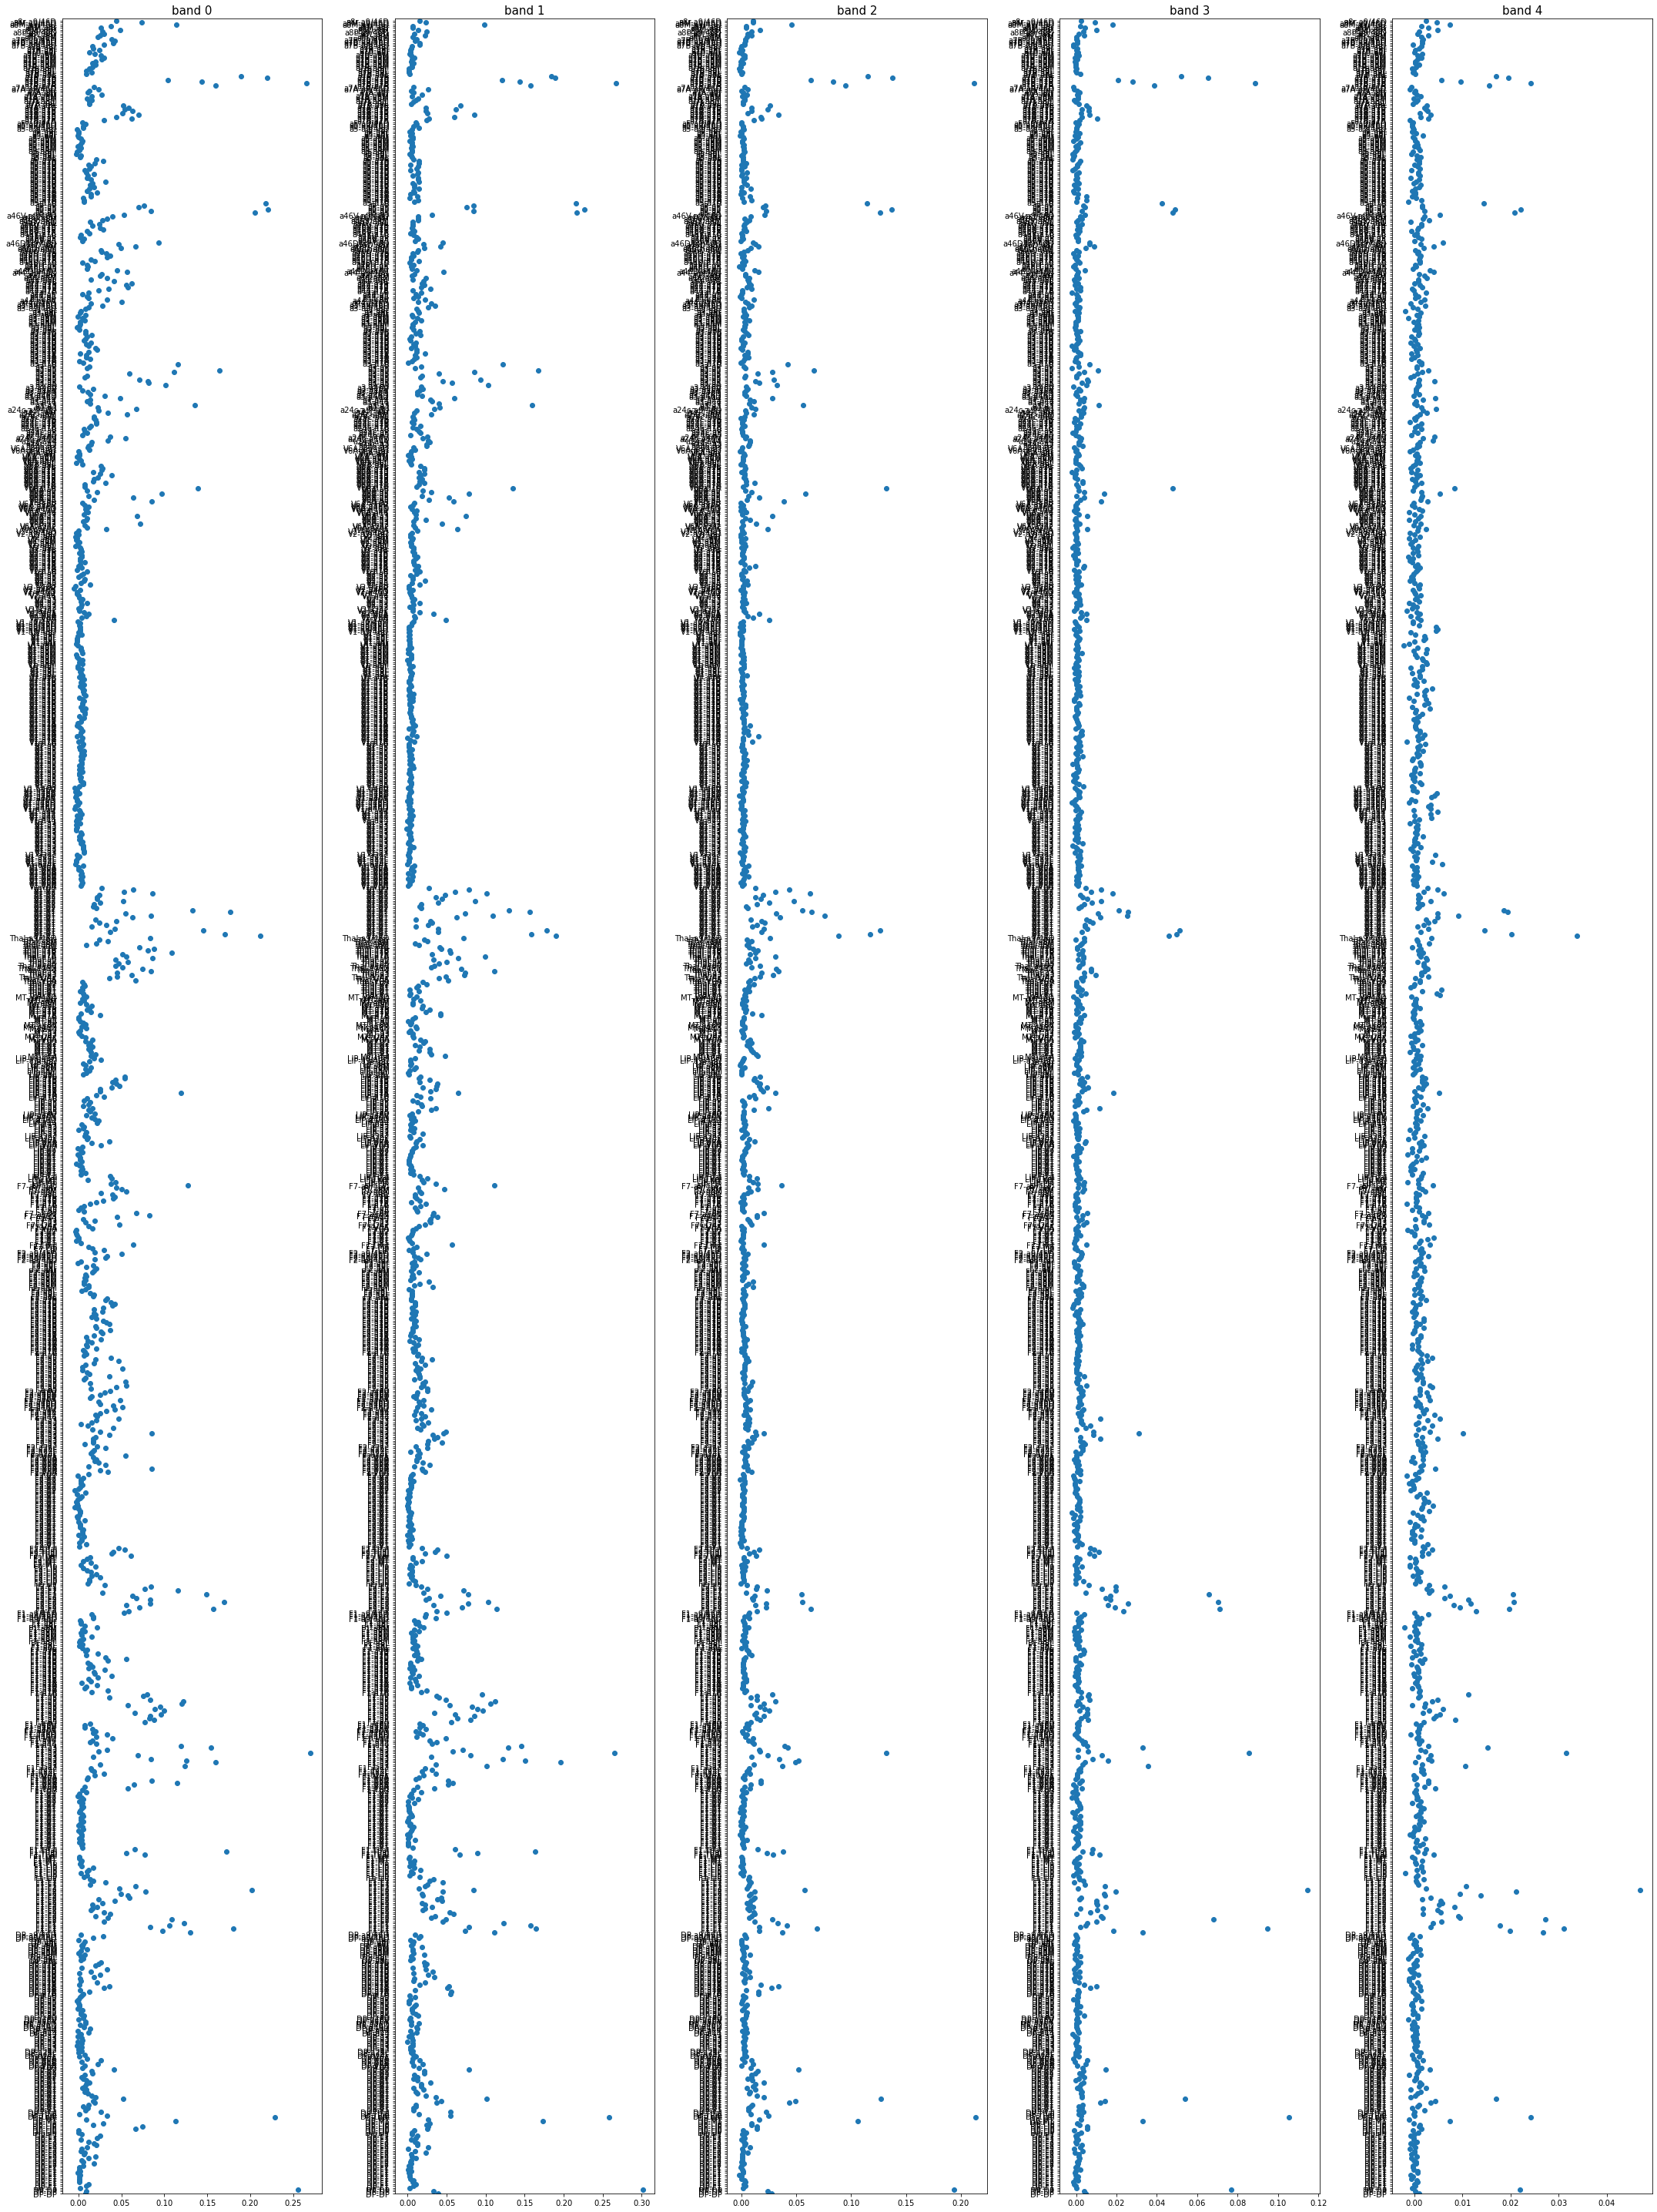

In [15]:
idx = np.argsort(coh.roi.values)
plt.figure(figsize=(30,40))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(med[idx,i], range(coh.sizes['roi']), 'o')
    plt.title(f'band {i}', fontsize=15)
    plt.ylim(0, coh.sizes['roi'])
    plt.yticks(range(coh.sizes['roi']),coh.roi.values[idx])
plt.tight_layout()
plt.savefig('img/surr_median.png')

#### KS-test

In [16]:
from scipy.stats import ks_2samp

In [17]:
#### Loading data
#coh      = xr.load_dataarray('data/coh_orig.nc')
#coh_surr = xr.load_dataarray('data/coh_surr.nc')
#to_netcdf('data/coh_orig.nc')

In [17]:
def ks_test(data, data_surr, verbose=False, n_jobs=1):
    from frites.utils import parallel_func
    
    def _for_band(band):
        ks = np.zeros(data.shape[1])
        for i in range( data.shape[1] ):
            ks[i] = ks_2samp(data[:,i,band,:].flatten(),data_surr[:,:,i,band,:].flatten(), alternative='two-sided')[1]
        return ks
    # define the function to compute in parallel
    parallel, p_fun = parallel_func( _for_band, n_jobs=n_jobs, 
                                     verbose=verbose, total=coh.shape[2]
                                   )
    ks = parallel(p_fun(band) for band in range(coh.shape[2]))
    return ks

In [18]:
ks_stats   = np.zeros((coh.sizes['roi'],coh.sizes['freqs']))
#j          = 0
#for i in tqdm( range( coh.sizes['roi'] ) ):
#    #for j in range( coh.sizes['freqs'] ):
#    ks_stats[i,j]=ks_2samp(aux1[:,i,j,:].flatten(),aux2[:,:,i,j,:].flatten())[1]
ks         = ks_test(coh.values,coh_surr.values,True,-1)

  0%|          |  : 0/5 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


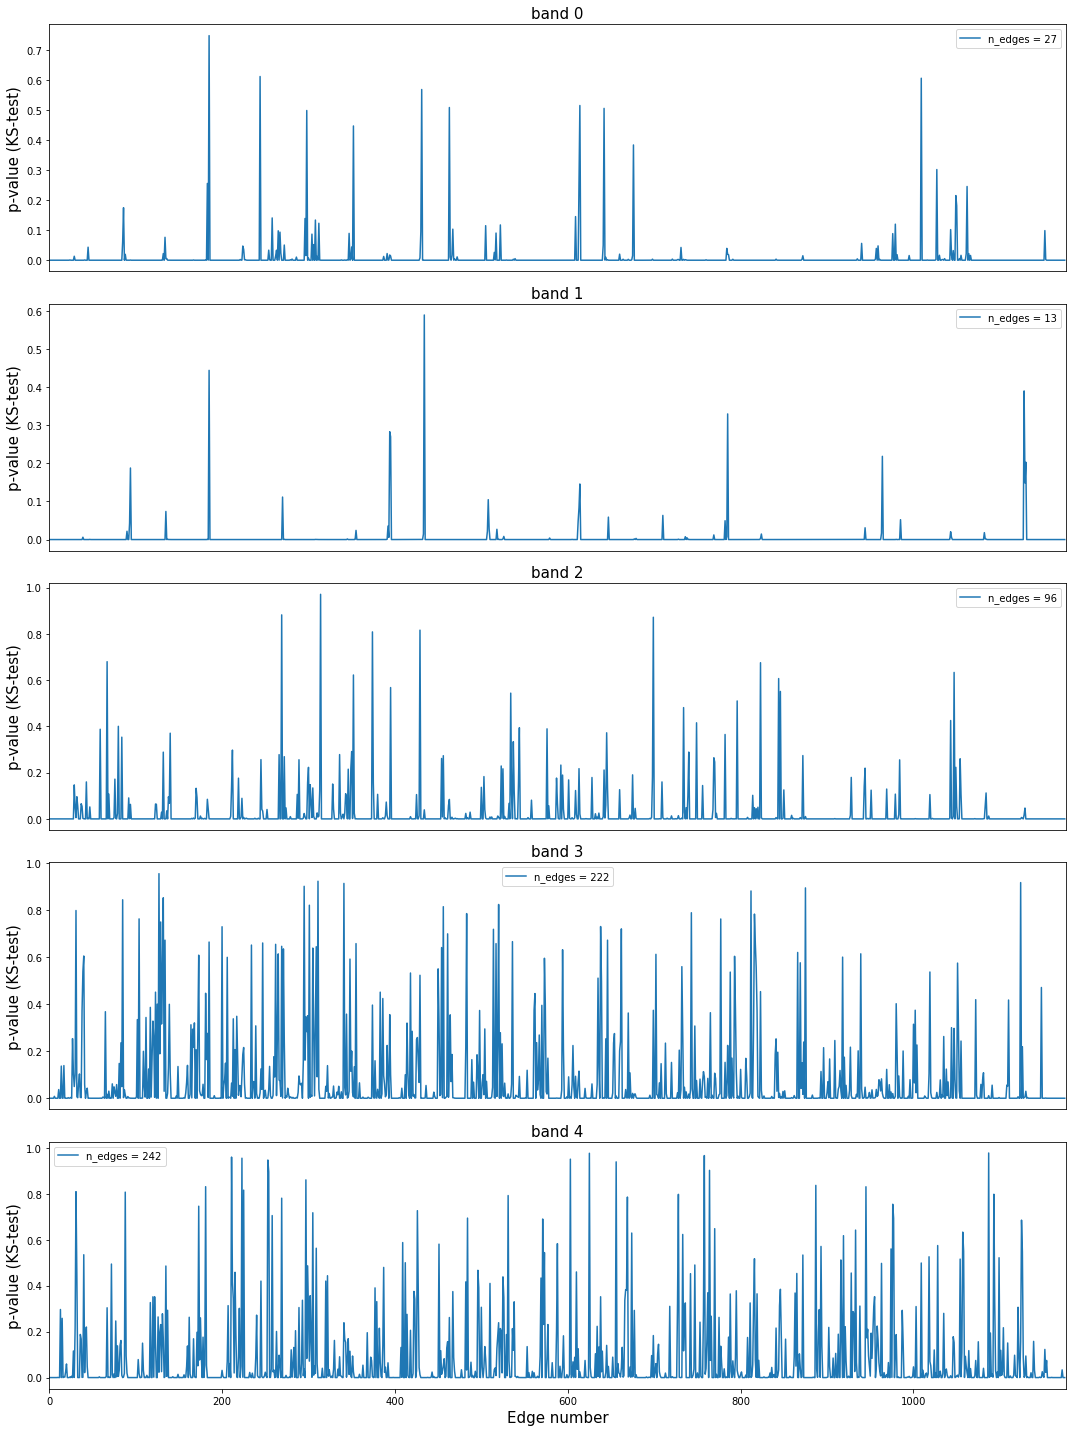

In [19]:
plt.figure(figsize=(15,20))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(ks[i], label=f'n_edges = {np.sum(ks[i]>0.1)}')
    plt.ylabel('p-value (KS-test)', fontsize=15)
    if i == 4: plt.xlabel('Edge number', fontsize=15)
    else: plt.xticks([])
    plt.title(f'band {i}', fontsize=15)
    plt.xlim([0,ks[i].shape[0]])
    plt.legend()
plt.tight_layout()
plt.savefig('img/ks_test.png', dpi=200)

In [20]:
ks_mat = np.zeros((5,data.sizes['roi'],data.sizes['roi']))
for i in range(5):
    idx         = ks[i] > 0.1
    x_s_i,x_t_i = x_s[idx], x_t[idx]
    ks_mat[i,x_s_i,x_t_i] = ks_mat[i,x_t_i,x_s_i] = 1

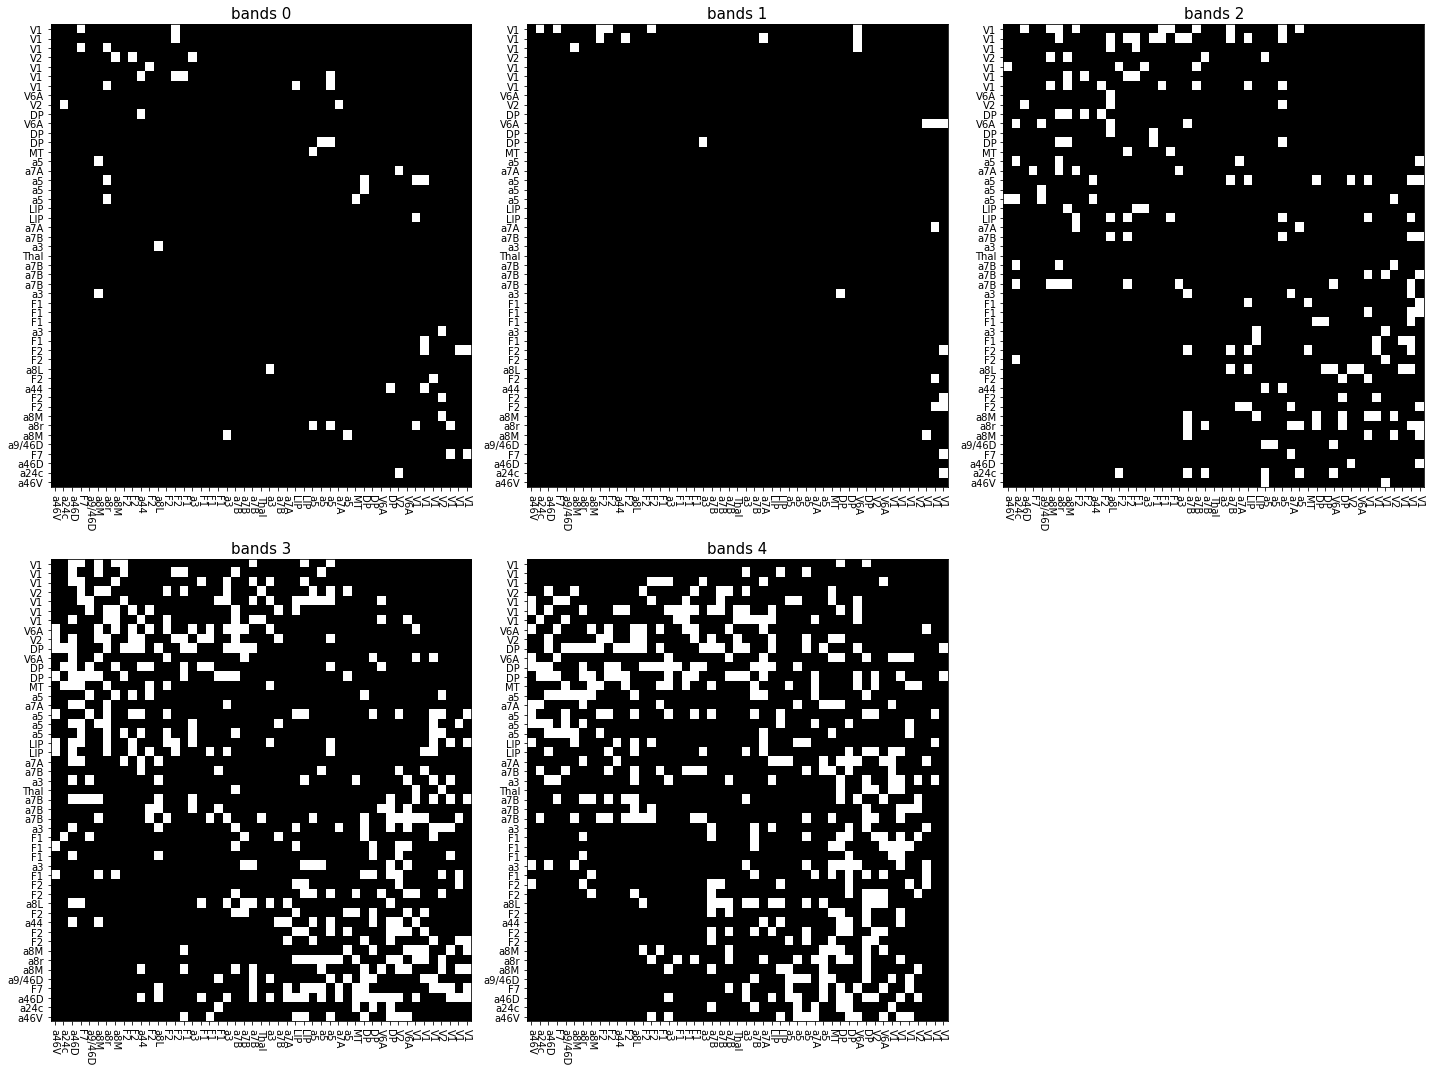

In [21]:
plt.figure(figsize=(20,15))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(ks_mat[i], aspect='auto', origin = 'lower', cmap='gray')
    plt.xticks(range(data.sizes['roi']), data.roi.values, rotation=270)
    plt.yticks(range(data.sizes['roi']), data.roi.values)
    plt.title(f'bands {i}', fontsize=15)
plt.tight_layout()

### Comparing with dFC

In [24]:
from GDa.fc.dFC import dFC

In [25]:
#x_s, x_t  = np.triu_indices(data.sizes['roi'], k=1)
#pairs     = np.array([x_s,x_t]).T

In [26]:
dfc = []
for f_0,f_1 in foi:
    dfc += [dFC(data,times=data.time,sfreq=data.attrs['fsample'], win_args=dict(slwin_len=.5, slwin_step=.02), 
               decim=10,roi=data.roi, f_low=f_0, f_high=f_1, pairs=pairs, n_jobs=-1)]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 0.1 - 6 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 6.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    9.6s
[Parallel(n_jobs=40)]: Done 125 tasks      | elapsed:    9.8s
[Parallel(n_jobs=40)]: Done 808 tasks      | elapsed:   10.3s
[Parallel(n_jobs=40)]: Done 8360 tasks      | elapsed:   11.9s
[Parallel(n_jobs=40)]: Done 21032 tasks      | elapsed:   14.6s
[Parallel(n_jobs=40)]: Done 25964 tasks      | elapsed:   15.9s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   16.6s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 6 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 14.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:   10.5s
[Parallel(n_jobs=40)]: Done 168 tasks      | elapsed:   10.6s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:   11.1s
[Parallel(n_jobs=40)]: Done 9600 tasks      | elapsed:   12.9s
[Parallel(n_jobs=40)]: Done 22272 tasks      | elapsed:   15.3s
[Parallel(n_jobs=40)]: Done 25330 tasks      | elapsed:   16.2s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   16.9s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 14 - 26 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 14.00, 26.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:   11.3s
[Parallel(n_jobs=40)]: Done 168 tasks      | elapsed:   11.4s
[Parallel(n_jobs=40)]: Done 1552 tasks      | elapsed:   12.0s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:   13.8s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:   16.3s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   17.0s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   17.5s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 26 - 42 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 26.00, 42.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:   12.2s
[Parallel(n_jobs=40)]: Done 170 tasks      | elapsed:   12.3s
[Parallel(n_jobs=40)]: Done 1560 tasks      | elapsed:   12.7s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:   14.5s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:   17.0s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   17.9s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   18.5s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 42 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 42.00, 80.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:   13.1s
[Parallel(n_jobs=40)]: Done 168 tasks      | elapsed:   13.2s
[Parallel(n_jobs=40)]: Done 1552 tasks      | elapsed:   13.7s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:   15.6s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:   18.3s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   19.1s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   19.8s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

In [27]:
dfc = xr.concat(dfc,dim="freqs")

In [28]:
dfc_surr = []
for f_0,f_1 in foi:
    dfc_surr += [dFC(data_surr.isel(seeds=0),times=data.time,sfreq=data.attrs['fsample'], win_args=dict(slwin_len=.5, slwin_step=.02), 
               decim=10,roi=data.roi, f_low=f_0, f_high=f_1, pairs=pairs, n_jobs=-1)]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 0.1 - 6 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 6.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    9.5s
[Parallel(n_jobs=40)]: Done 172 tasks      | elapsed:    9.7s
[Parallel(n_jobs=40)]: Done 1552 tasks      | elapsed:   10.2s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:   12.1s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:   14.7s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   15.6s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   16.2s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 6 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 14.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:   10.5s
[Parallel(n_jobs=40)]: Done 168 tasks      | elapsed:   10.7s
[Parallel(n_jobs=40)]: Done 1552 tasks      | elapsed:   11.2s
[Parallel(n_jobs=40)]: Done 6720 tasks      | elapsed:   12.6s
[Parallel(n_jobs=40)]: Done 13056 tasks      | elapsed:   13.9s
[Parallel(n_jobs=40)]: Done 20544 tasks      | elapsed:   15.6s
[Parallel(n_jobs=40)]: Done 25824 tasks      | elapsed:   17.1s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   18.1s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 14 - 26 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 14.00, 26.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:   11.3s
[Parallel(n_jobs=40)]: Done 168 tasks      | elapsed:   11.5s
[Parallel(n_jobs=40)]: Done 1552 tasks      | elapsed:   12.0s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:   13.8s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:   16.3s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   17.2s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   17.8s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 26 - 42 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 26.00, 42.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:   12.1s
[Parallel(n_jobs=40)]: Done 170 tasks      | elapsed:   12.2s
[Parallel(n_jobs=40)]: Done 1564 tasks      | elapsed:   12.6s
[Parallel(n_jobs=40)]: Done 10880 tasks      | elapsed:   14.6s
[Parallel(n_jobs=40)]: Done 23552 tasks      | elapsed:   17.2s
[Parallel(n_jobs=40)]: Done 26004 tasks      | elapsed:   18.1s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   18.7s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

Compute pairwise dFC (n_pairs=1176, decim=10)


Setting up band-pass filter from 42 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 42.00, 80.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:   12.9s
[Parallel(n_jobs=40)]: Done 170 tasks      | elapsed:   13.0s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:   13.6s
[Parallel(n_jobs=40)]: Done 6720 tasks      | elapsed:   14.7s
[Parallel(n_jobs=40)]: Done 13056 tasks      | elapsed:   16.2s
[Parallel(n_jobs=40)]: Done 20544 tasks      | elapsed:   18.0s
[Parallel(n_jobs=40)]: Done 25824 tasks      | elapsed:   19.7s
[Parallel(n_jobs=40)]: Done 26460 out of 26460 | elapsed:   20.6s finished


  0%|          |  : 0/1176 [00:00<?,       ?it/s]

In [29]:
dfc_surr = xr.concat(dfc_surr,dim="freqs")

In [30]:
dfc = dfc.stack(observations=("trials","times"))

In [33]:
dfc_surr = dfc_surr.stack(observations=("trials","times"))

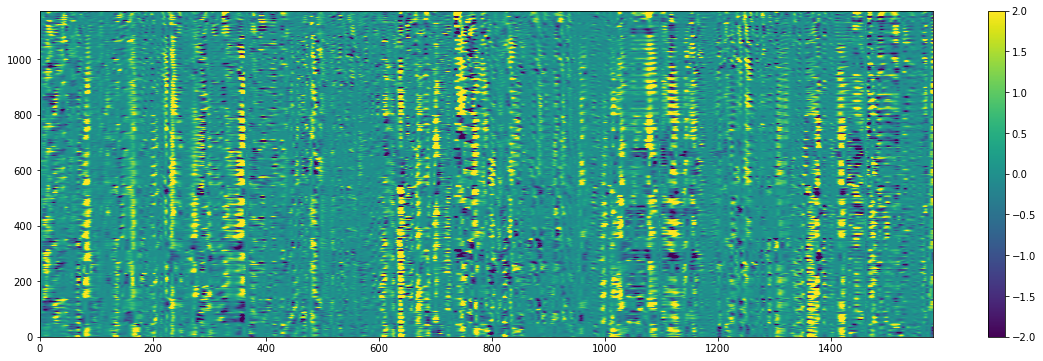

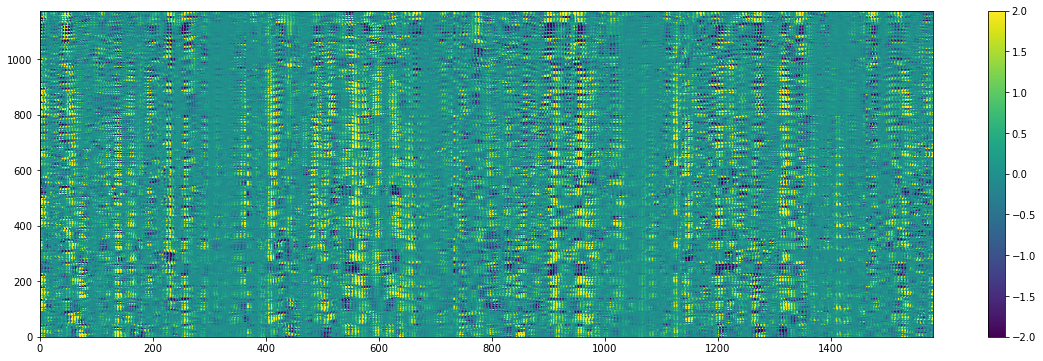

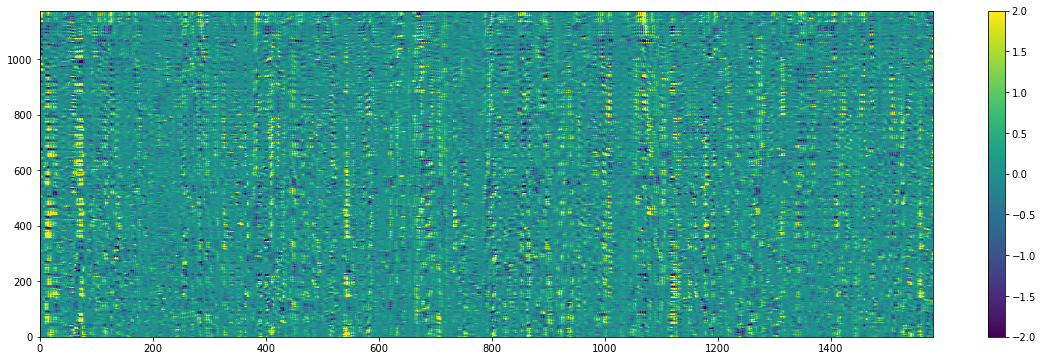

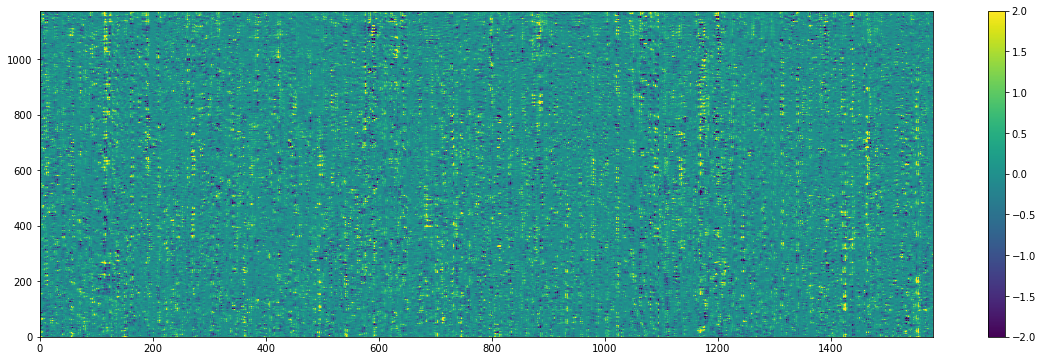

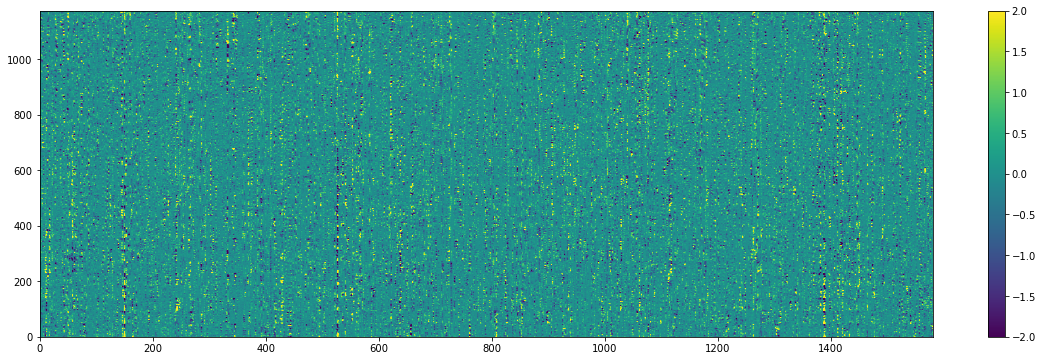

In [31]:
dfc_surr in range(5):
    plt.figure(figsize=(20,6))
    plt.imshow( dfc[i,...,:1580], aspect='auto', origin='lower', vmin=-2, vmax=2)
    plt.colorbar()

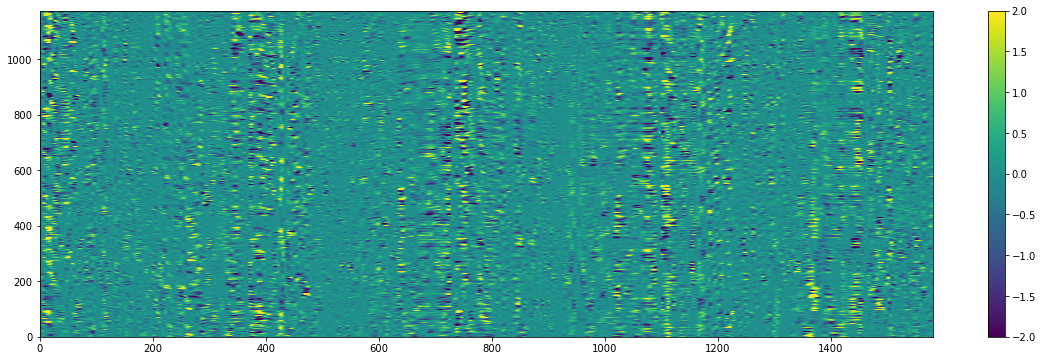

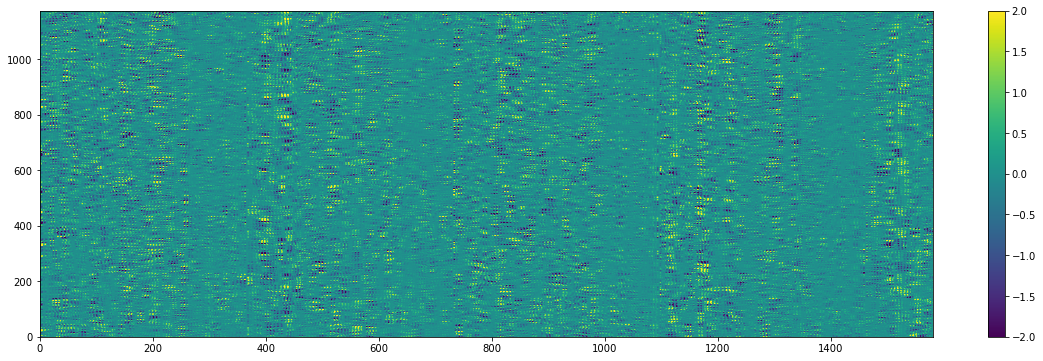

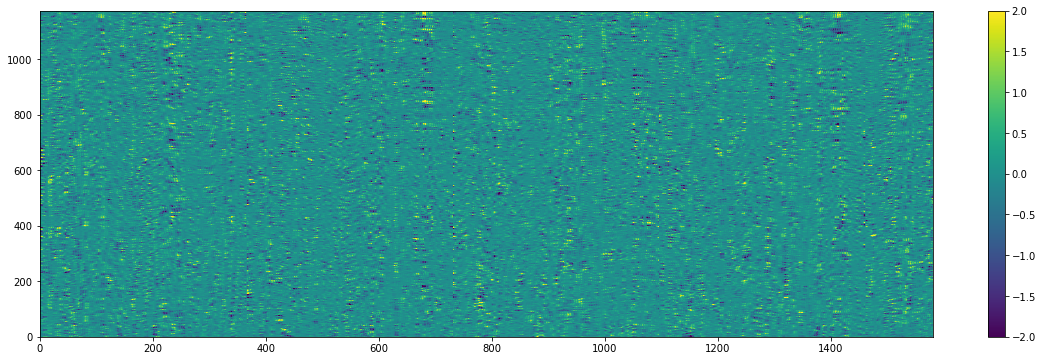

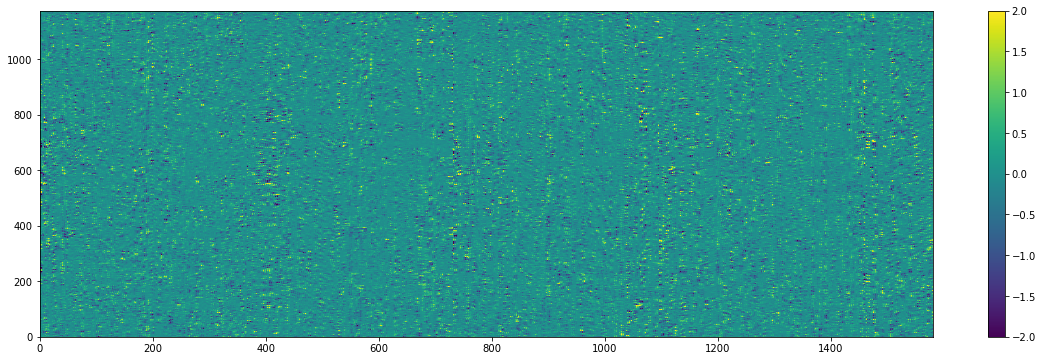

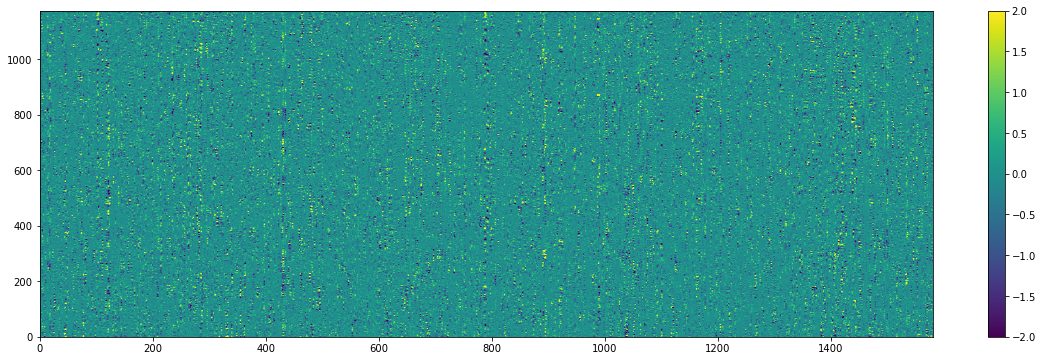

In [38]:
for i in range(5):
    plt.figure(figsize=(20,6))
    plt.imshow( dfc_surr[i,...,:1580], aspect='auto', origin='lower', vmin=-2, vmax=2)
    plt.colorbar()

In [ ]:
bins = np.linspace(-5,5,100)
for r in tqdm( range(coh.sizes['roi']) ):
    plt.figure(figsize=(8,15))
    count = 1
    for i in range(5):
        plt.subplot(5,1,count)
        plt.suptitle(f'link={coh.roi.values[r]}', fontsize=15)
        plt.hist( dfc_surr.isel(freqs=i,roi=r).values.flatten(), bins=bins, density=True, histtype='step', fill=False, color='r', label='Surrogate');
        plt.hist( dfc.isel(freqs=i, roi=r).values.flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original');
        plt.title(f'band {i}', fontsize=15)
        plt.ylabel('#', fontsize=15) 
        plt.legend()
        count += 1
    plt.tight_layout()
    plt.xlabel(f'Coherence', fontsize=15)
    plt.savefig(f'img/surr_dfc/surr_dist_roi{r}_dfc.png')
    plt.close()

 85%|████████▌ | 1004/1176 [08:37<01:21,  2.11it/s]

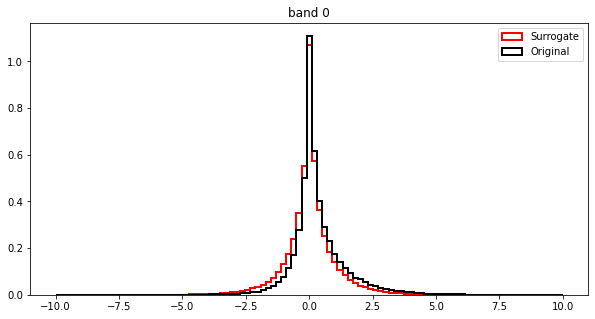

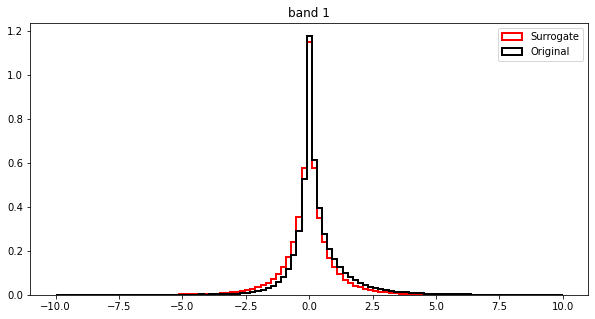

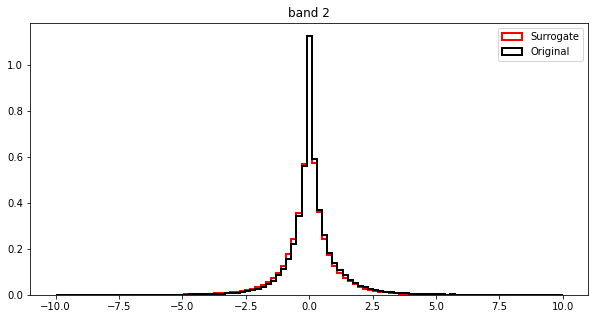

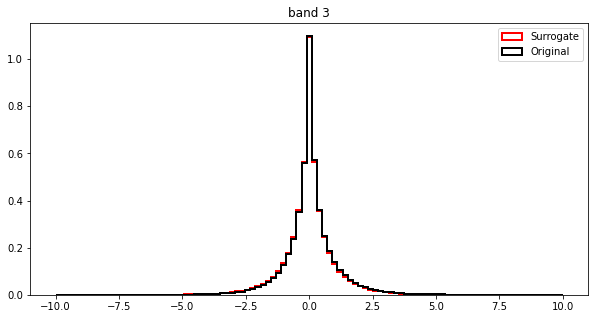

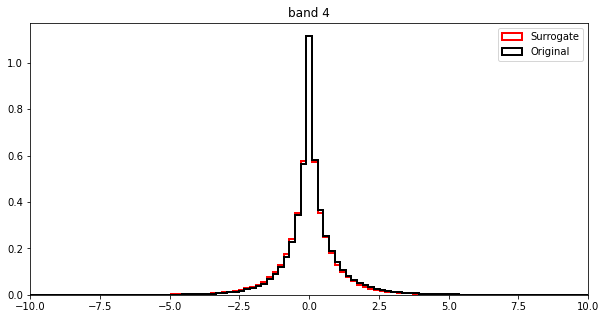

In [36]:
bins = np.linspace(-10,10,100)
for i in range(5):
    plt.figure(figsize=(10,5))
    plt.hist( dfc_surr.isel(freqs=i, roi=0).values.flatten(), bins=bins,  color='red', label='Surrogate', density=True, histtype='step', fill=False, lw=2)
    plt.hist( dfc.isel(freqs=i, roi=0).values.flatten(), bins=bins,  color='k', label='Original', density=True, histtype='step', fill=False, lw=2)
    plt.title(f'band {i}')
    plt.legend()
plt.xlim(-10,10);

In [35]:
dfc_surr

<xarray.DataArray 'dfc' (freqs: 5, roi: 1176, observations: 197100)>
array([[[-5.10352740e-02,  2.64221997e-01,  5.98045707e-01, ...,
         -1.72659520e-01, -2.79432549e-01, -2.98632609e-01],
        [-2.02265468e-01, -5.03665322e-01, -8.02514700e-01, ...,
         -3.65290578e-02, -8.87952581e-03,  9.03502510e-02],
        [ 1.68631281e-01, -1.20200892e-01, -4.22366287e-01, ...,
          4.04830315e-02,  5.28406418e-02,  3.24888450e-02],
        ...,
        [-1.96527025e-01, -8.25668407e-02, -6.68149295e-03, ...,
          5.27842242e-01,  2.67395327e-01,  6.54128293e-02],
        [-4.90956244e-02, -1.36312267e-02, -1.71422215e-04, ...,
          2.74506762e-01,  1.77631261e-01,  5.74846959e-02],
        [ 2.35326948e-01,  9.13424104e-02,  7.82804458e-03, ...,
          5.87912975e-01,  6.13741647e-01,  6.28395341e-01]],

       [[ 6.45837793e-05,  2.48258559e-01,  7.10967681e-01, ...,
         -9.83504503e-01, -1.37528886e+00, -5.42955245e-01],
        [-4.32275618e-05, -1.12114910e+00, -2.77969074e+00, ...,
          6.36622165e-02, -5.39374782e-02, -4.87150297e-02],
        [-1.49771966e-04, -4.17060435e-01, -1.15561042e+00, ...,
          9.51154410e-02,  3.35637806e-02, -6.16301761e-03],
...
        [-5.66207807e-06,  1.52799914e-01, -1.88552122e+00, ...,
         -2.45725947e+00, -1.82816877e+00, -7.36944563e+00],
        [ 8.86418866e-07,  2.69011617e-02, -1.74466199e-01, ...,
          1.12673619e+00, -7.68914614e-01, -3.03948438e-01],
        [-1.84798606e-06,  2.88681551e-01,  3.36837457e-01, ...,
         -1.70616761e+00,  2.21258506e+00,  8.05984529e-01]],

       [[ 2.56010814e-07,  1.04598454e-01, -8.68783990e-01, ...,
          1.88834645e-01,  4.81138514e-01,  4.22032620e-01],
        [-3.93093358e-06, -9.54041434e-02,  5.76262034e-02, ...,
          6.98902093e-02,  3.10652589e-01,  4.39602328e-01],
        [-4.47231259e-06, -1.33378317e-01,  6.77295420e-01, ...,
         -5.28490028e-01, -4.39961097e-01, -8.01672911e-01],
        ...,
        [-1.44429597e-06,  6.46300035e-03,  7.68038839e-01, ...,
         -1.67416442e+00, -4.46220686e-01,  3.65546130e-01],
        [-1.32936761e-06,  8.15458296e-03,  3.77887048e-01, ...,
         -9.61812541e-02,  4.20033008e-02, -9.89775418e-02],
        [ 2.39972406e-06,  8.52190690e-03,  7.77762100e-01, ...,
          1.30009242e-01, -1.47378644e-01, -3.92967417e-01]]])
Coordinates:
  * roi           (roi) <U11 'a24c-a46V' 'a46D-a46V' ... 'V1-V1' 'V1-V1'
  * observations  (observations) MultiIndex
  - trials        (observations) int64 1 1 1 1 1 1 1 ... 886 886 886 886 886 886
  - times         (observations) float64 -0.65 -0.64 -0.63 ... 2.97 2.98 2.99
Dimensions without coordinates: freqs
Attributes:
    sfreq:    1000.0
    decim:    10